# Easy 21 Environment Implementation

In [ ]:
import random
from enum import Enum
import copy


class State:
    def __init__(self, dealer, player, is_terminal=0):
        self.dealer = dealer.value
        self.player = player.value
        self.is_terminal = is_terminal


# todo STICK/HIT
class Action(Enum):
    stick = 0
    hit = 1

    @staticmethod
    def to_action(n):
        return Action.stick if n == 0 else Action.hit


class Card:
    def __init__(self, first_black_card=0):
        self.value = random.randint(1, 10)
        if first_black_card or random.randint(1, 3) != 3:
            self.is_black = 1
        else:
            self.is_black = 0
            self.value = -self.value


class Environment:

    def __init__(self):
        self.player = 21
        self.dealer = 10
        self.actions = 2

    def get_start_state(self):
        s = State(Card(True), Card(True))
        return s

    def step(self, state, action):
        next_state = copy.copy(state)
        reward = 0
        if action == Action.hit:
            next_state.player += Card().value
            if next_state.player > 21 or next_state.player < 1:
                next_state.is_terminal = 1
                reward = -1
                return next_state, reward
        elif action == Action.stick:
            while not next_state.is_terminal:
                next_state.dealer += Card().value
                if next_state.dealer > 21 or next_state.dealer < 1:
                    next_state.is_terminal = 1
                    reward = 1
                elif next_state.dealer > 17:
                    next_state.is_terminal = 1
                    if next_state.player > next_state.dealer:
                        reward = 1
                    elif next_state.player < next_state.dealer:
                        reward = -1
        return next_state, reward



Test

In [ ]:
s = State(Card(True), Card(True))
a = Action.hit
env = Environment()
while not s.is_terminal:
    print("state: dealer = %s, player = %s,is_terminal:%d" % (s.dealer, s.player, s.is_terminal))
    if s.player >= 17:
        a = Action.stick
    s, r = env.step(s, a)
print("terminal state: dealer = %s, player = %s" % (s.dealer, s.player))
print("reward = %d" % (r))

state: dealer = 6, player = 8,is_terminal:0
state: dealer = 6, player = 11,is_terminal:0
state: dealer = 6, player = 15,is_terminal:0
state: dealer = 6, player = 16,is_terminal:0
terminal state: dealer = 6, player = 22
reward = -1


# Monte-Carlo Control in Easy21

In [31]:
import numpy as np


class MC_Agent:
    def __init__(self, environment, N0):
        self.N0 = N0
        self.env = environment

        # N(s) is the number of times that state s has been visited
        # N(s,a) is the number of times that action a has been selected from state s.
        # Initialize N, value func.V,action value func. Q to zero. 
        self.N = np.zeros((self.env.dealer, self.env.player, self.env.actions))
        self.Q = np.zeros((self.env.dealer, self.env.player, self.env.actions))
        self.V = np.zeros((self.env.dealer, self.env.player))

        self.win_counts = 0
        self.episodes = 0

    # get optimal action, with ε-greedy exploration strategy

    def get_action(self, state):
        dealer_idx = state.dealer - 1
        player_idx = state.player - 1
        N_visits = sum(self.N[dealer_idx, player_idx, :])

        # εt = N0/(N0 + N(st)
        epsilon = self.N0 / (self.N0 + N_visits)

        # epsilon greedy policy
        if random.random() < epsilon:
            r_action = Action.hit if random.random() < 0.5 else Action.stick
            return r_action
        else:
            action = Action.to_action(np.argmax(self.Q[dealer_idx, player_idx, :]))
            return action

    def train(self, episodes):

        # Loop episodes
        for episode in range(episodes):
            episode_pairs = []

            # get initial state for current episode
            s = self.env.get_start_state()

            # Execute until game ends
            while not s.is_terminal:
                # get action with epsilon greedy policy
                a = self.get_action(s)

                # store action state pairs
                episode_pairs.append((s, a))

                # update visits
                # N(s) is the number of times that state s has been visited
                # N(s,a) is the number of times that action a has been selected from state s. 
                self.N[s.dealer - 1, s.player - 1, a.value] += 1

                # execute action
                s, r = self.env.step(s, a)

            self.win_counts = self.win_counts + 1 if r == 1 else self.win_counts

            # Update action value func. Q
            for curr_s, curr_a in episode_pairs:
                # print s.dealer, s.player, s.r, a
                dealer_idx = curr_s.dealer - 1
                player_idx = curr_s.player - 1
                action_idx = curr_a.value

                # Use a time-varying scalar step-size of αt = 1/N(st,at) 
                step = 1.0 / self.N[dealer_idx, player_idx, action_idx]

                error = r - self.Q[dealer_idx, player_idx, action_idx]
                self.Q[dealer_idx, player_idx, action_idx] += step * error

        self.episodes += episodes
        win_rates = float((self.win_counts) / self.episodes)
        print("player win rates = %f " % (win_rates))

        # update value func. V
        for dealer_idx in range(self.env.dealer):
            for player_idx in range(self.env.player):
                self.V[dealer_idx, player_idx] = max(self.Q[dealer_idx, player_idx, :])

    def plot_frame(self, ax):
        def get_stat_val(x, y):
            return self.V[x, y]

        X = np.arange(0, self.env.dealer, 1)
        Y = np.arange(12, self.env.player, 1)
        X, Y = np.meshgrid(X, Y)
        Z = get_stat_val(X, Y)
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        return surf


In [32]:
N0 = 100
agent = MC_Agent(Environment(), N0)

for i in range(10):
    agent.train(50000)

player win rates = 0.564120 
player win rates = 0.576450 
player win rates = 0.580700 
player win rates = 0.583255 
player win rates = 0.584972 
player win rates = 0.586737 
player win rates = 0.587471 
player win rates = 0.588150 
player win rates = 0.588167 
player win rates = 0.588786 


In [33]:
# N0 = 1
# agent = MC_Agent(Environment(), N0)
# for i in range (10):
#     agent.train(50000)

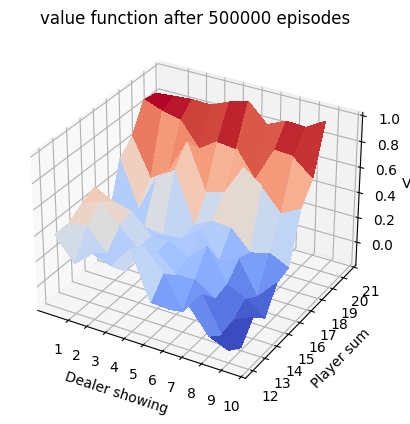

In [34]:
#plot value func V

import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
agent.plot_frame(ax)
plt.title('value function after %d episodes' % agent.episodes)
ax.set_xlabel('Dealer showing')
ax.set_ylabel('Player sum')
ax.set_zlabel('V(s)')
ax.set_xticks(range(1, agent.env.dealer + 1))
ax.set_yticks(range(12, agent.env.player + 1))
plt.show()


In [35]:

N0 = 100
mc_agent = MC_Agent(Environment(), N0)
mc_agent.train(int(50000))
Qmc = mc_agent.Q


player win rates = 0.564460 


# TD Learning in Easy21

SARSA

In [49]:
import numpy as np
import random


class Sarsa_Agent:
    def __init__(self, environment, N0):
        self.N0 = N0
        self.env = environment
        self.mse = []

        # N(s) is the number of times that state s has been visited
        # N(s,a) is the number of times that action a has been selected from state s.
        # Initialize N,action value func. Q to zero.
        self.N = np.zeros((self.env.dealer, self.env.player, self.env.actions))
        self.Q = np.zeros((self.env.dealer, self.env.player, self.env.actions))

        self.win_counts = 0
        self.episodes = 0

    # ε-greedy policy; same to MC
    def train_get_action(self, state):
        dealer_idx = state.dealer - 1
        player_idx = state.player - 1
        N_visits = sum(self.N[dealer_idx, player_idx, :])
        # εt = N0/(N0 + N(st)
        epsilon = self.N0 / (self.N0 + N_visits)

        # epsilon greedy policy
        if random.random() < epsilon:
            r_action = Action.hit if random.random() < 0.5 else Action.stick
            return r_action
        else:
            action = Action.to_action(np.argmax(self.Q[dealer_idx, player_idx, :]))
            return action

    def train(self, episodes):

        # Loop episodes
        for episode in range(episodes):

            # get initial state for current episode
            s = self.env.get_start_state()
            a = self.train_get_action(s)

            # play game
            while not s.is_terminal:

                # execute action
                next_s, r = self.env.step(s, a)
                dealer_idx = s.dealer - 1
                player_idx = s.player - 1
                # update visits
                self.N[dealer_idx, player_idx, a.value] += 1

                if not next_s.is_terminal:
                    # choose next action with epsilon greedy policy
                    next_a = self.train_get_action(next_s)
                    dealer_idx_new = next_s.dealer - 1
                    player_idx_new = next_s.player - 1
                    new_Q = self.Q[dealer_idx_new, player_idx_new, a.value]
                    a = next_a
                else:
                    new_Q = 0
                s = next_s
                # alpha = 1.0 / (self.N[dealer_idx, player_idx, a.value])
                alpha = 1
                td_error = r + new_Q - self.Q[dealer_idx, player_idx, a.value]
                self.Q += alpha * td_error

            self.win_counts = self.win_counts + 1 if r == 1 else self.win_counts
            mse1 = np.mean((self.Q - Qmc) ** 2)
            print(self.Q)

            self.mse.append(mse1)

        self.episodes += episodes
        win_rates = float((self.win_counts) / self.episodes)
        print("player win rates = %f " % (win_rates))
        print(self.mse)



In [51]:
N0 = 100
agent = Sarsa_Agent(Environment(), N0)

for i in range(10):
    agent.train(2)

[[[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  

In [38]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)



[[[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  

C:\Users\winni\AppData\Local\Temp\ipykernel_9856\3432926696.py:66: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = 1.0 / (self.N[dealer_idx, player_idx, a.value])
C:\Users\winni\AppData\Local\Temp\ipykernel_9856\3432926696.py:68: RuntimeWarning: invalid value encountered in double_scalars
  self.Q += alpha*td_error


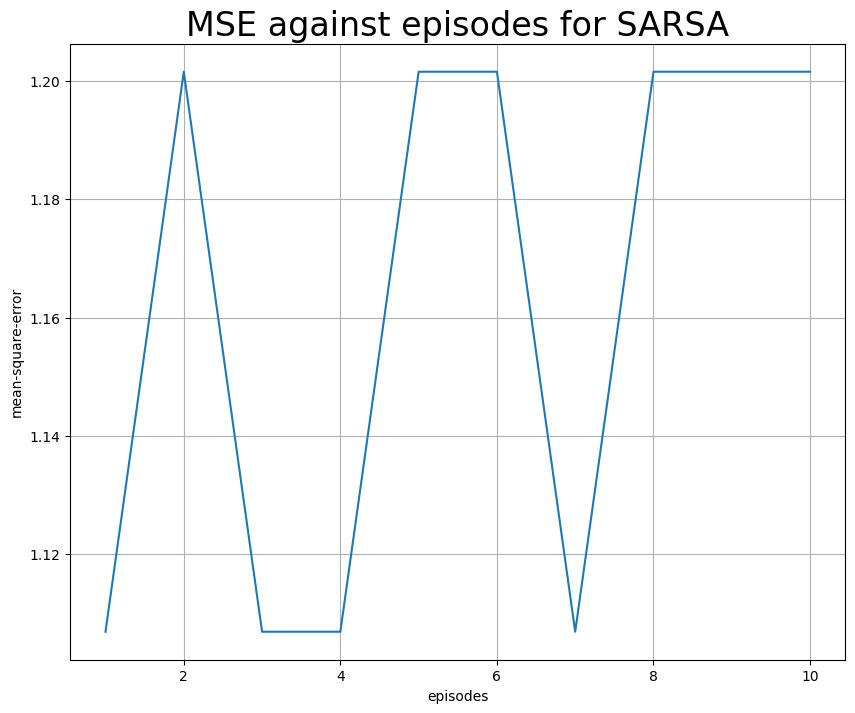

In [39]:
N0 = 100
agent = Sarsa_Agent(Environment(), N0)
agent.train(50)

fig, ax = plt.subplots()
ax.plot(list(range(1, len(agent.mse) + 1)), agent.mse)
ax.set(xlabel='episodes', ylabel='mean-square-error')
ax.set_title('MSE against episodes for SARSA', fontsize=24)
ax.grid()
ax.figure.set_size_inches(10, 8)
ax.xaxis.set_minor_locator(MultipleLocator(1000))
plt.show()

